# Mindscope_qc demo notebook
# Paired plane registration

This code demonstrates the use of the paired_plane_registration module. Given an ophys_exeriment_id,
 the functions will find the paired experiment_id and load the rigid translations generated by
suite2p. One can then take those translations and load both experiment raw h5 files and apply either
the original or the paired translations. Plotting functions are included to examine the results of these
shifts. Generating chunked movies (every 10mins) and averaging + saving as gifs is helpful to examine
the effects of paired plane signal crosstalk.

Written by: Matt James Davis

Last updated: 01/18/2023

In [3]:
import mindscope_qc.data_access.from_lims as from_lims
import mindscope_qc.pipeline_dev.paired_plane_registration as ppr

import matplotlib.pyplot as plt


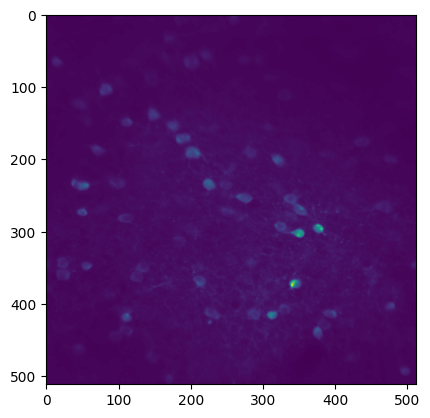

In [4]:
# example average 

eid = 1198901240
img = plt.imread(from_lims.get_average_intensity_projection_filepath(eid))

plt.imshow(img)

# One session pair example

In [6]:
# get the paired ID

eid = 1198901240
paired_id = ppr.get_paired_plane_id(eid)
paired_id

1198901242

In [ ]:
[1198901240, 1198901242]

In [8]:
# Load the shift for plane1 and plane 2

session_path = ppr.session_path_from_eid(eid)\
p1_shift = ppr.get_s2p_rigid_motion_transform(eid)
p2_shift = ppr.get_s2p_rigid_motion_transform(paired_id)

p1_shift

,framenumber,x,y,x_pre_clip,y_pre_clip,correlation,is_valid
0,0,5,3,5,3,0.020158,True
1,1,5,5,5,5,0.019160,True
2,2,5,3,5,3,0.019804,True
3,3,5,3,5,3,0.019163,True
4,4,4,8,4,8,0.018908,True
...,...,...,...,...,...,...,...
39103,39103,-14,-26,-14,-26,0.010400,True
39104,39104,-14,-26,-14,-26,0.010487,True
39105,39105,-14,-26,-14,-26,0.010882,True
39106,39106,-14,-26,-14,-26,0.010098,True


In [ ]:
# (optional) calculates the the slope of linear regression between two plane shifts

pairs = ppr.get_paired_slope(session_path)
pairs


# Many session statistics
Useful to calculate relationship between paired plane shifts across a population of experiment pairs 

In [ ]:
# get all sessions
sessions_ids = [...]

paired_lm = ppr.paired_shifts_regression(session_ids)

# Plotting functions (one session)

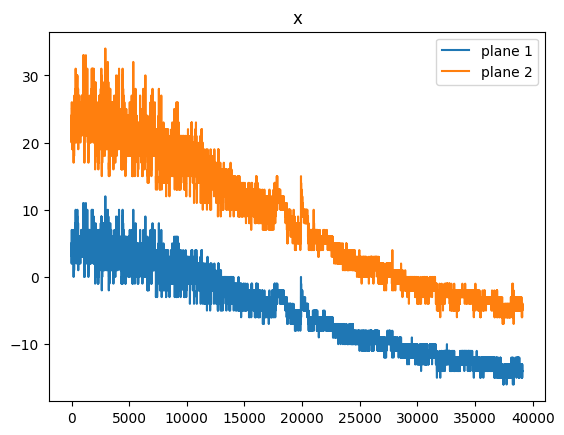

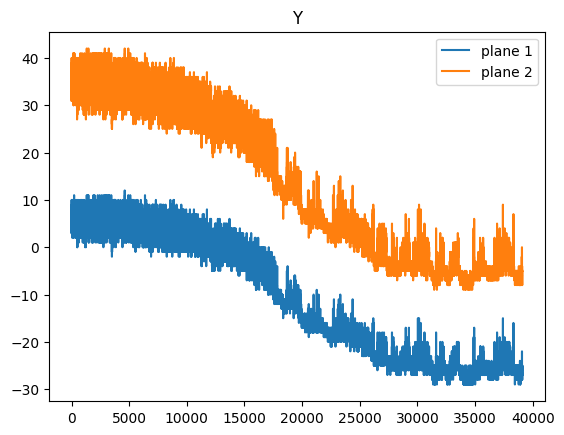

In [10]:
# plot x and y shifts for plane 1 and plane 2

fig, ax = plt.subplots()
plt.plot(p1_shift.x, label='plane 1')
plt.plot(p2_shift.x, label='plane 2')
ax.set_title('x')
# show legend
plt.legend()

fig, ax = plt.subplots()
plt.plot(p1_shift.y, label='plane 1')
plt.plot(p2_shift.y, label='plane 2')
ax.set_title('Y')
# show legend
plt.legend()


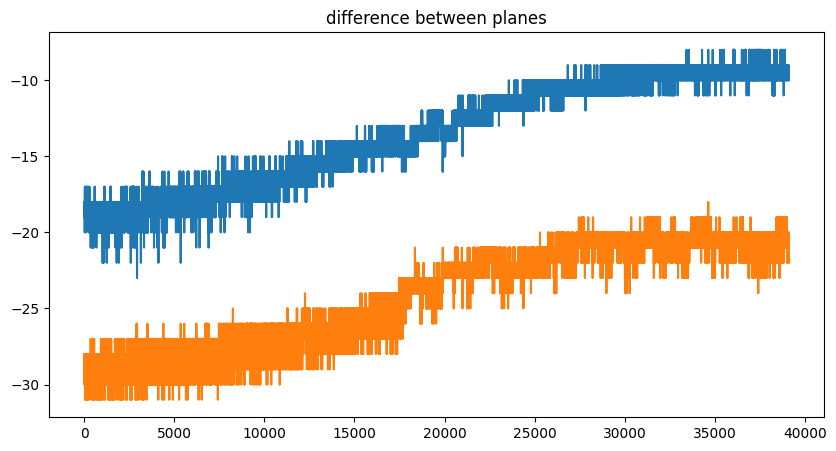

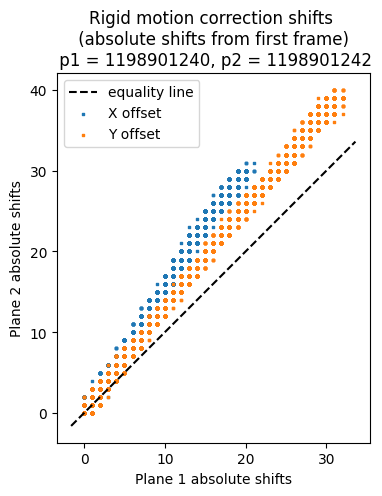

In [11]:
ppr.plot_paired_shifts(p1_shift, p2_shift ,eid, paired_id)

r-squared: 0.9947944781426528
r-squared: 0.9982094617229013


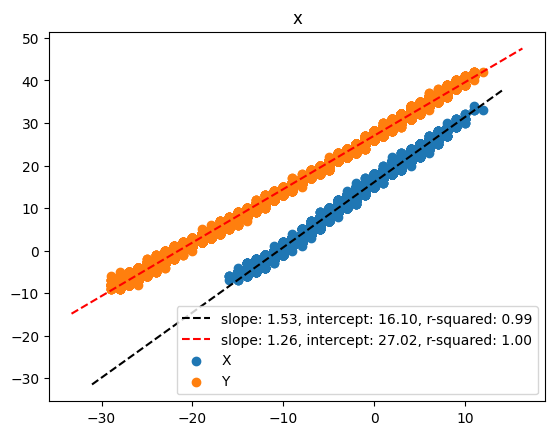

In [15]:
# not absolute shifts, deviations from 1 indicate that two planes are shifted to the same magnitude,
# despite being perfectly correlated.

ppr.plot_paired_shifts_regression(p1_shift, p2_shift)

In [16]:
# get images from original and paired shifted movies (average block_size number frames from start of movie)
projections_dict = ppr.paired_planes_shifted_projections(eid, block_size=1000)

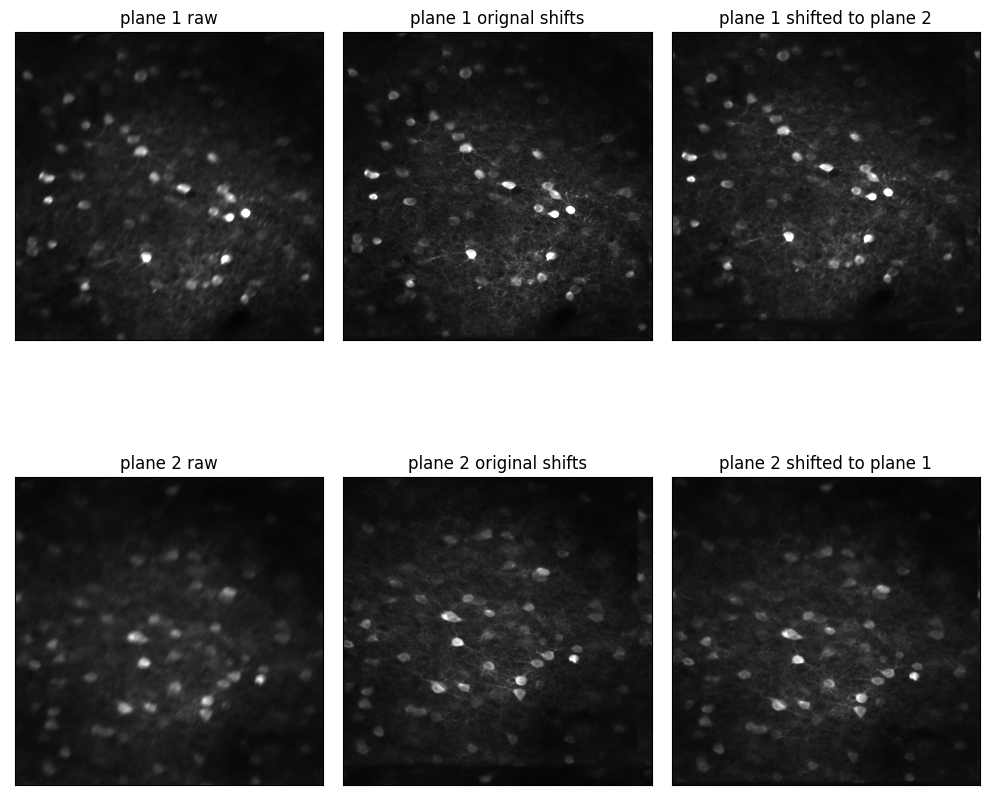

In [19]:
ppr.fig_paired_planes_shifted_projections(projections_dict)

In [ ]:
# kde hist of slopes
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=paired_lm, x='slope_x', ax=ax)
sns.kdeplot(data=paired_lm, x='slope_y', ax=ax)


# swarm of slopes
fig, ax = plt.subplots(figsize=(10, 5))
sns.swarmplot(data=paired_lm, y='slope_x', ax=ax)
sns.swarmplot(data=paired_lm, y='slope_y', ax=ax)
ax.set_title('slope of paired planes')

## Shift histograms

In [21]:
eid1 = eid
eid2 = ppr.get_paired_plane_id(eid1)

expt1_shifts = ppr.get_s2p_rigid_motion_transform(eid1)
expt2_shifts = ppr.get_s2p_rigid_motion_transform(eid2)

In [22]:
e1y, e1x = expt1_shifts.y, expt1_shifts.x
e2y, e2x = expt2_shifts.y, expt2_shifts.x

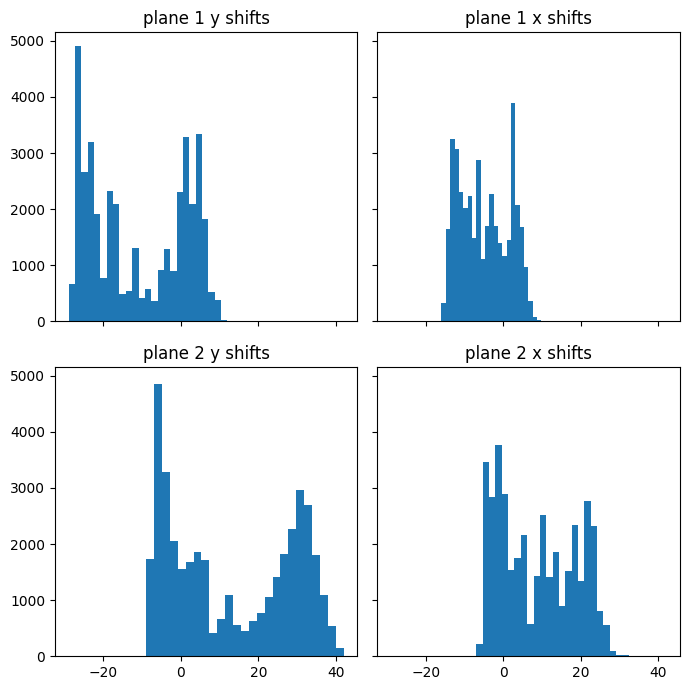

In [25]:
ppr.histogram_shifts(expt1_shifts, expt2_shifts)

Text(347.75631313131305, 0.5, 'y shift (pixels)')

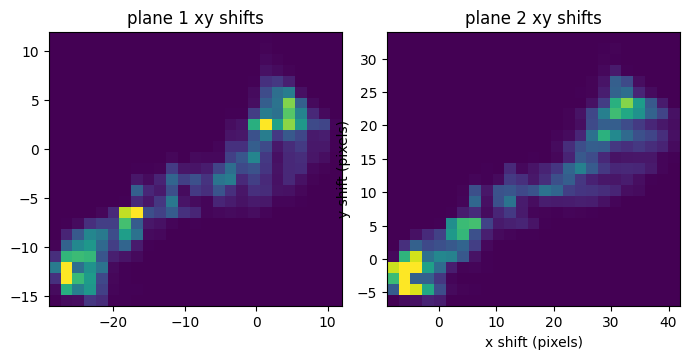

In [26]:
# %% HISTOGRAMS OF SHIFTS WITH 2D KDE

# get counts for 2d kde
counts, xedges, yedges = np.histogram2d(e1y, e1x, bins=25)
vmax = np.max(counts)/2

# make hist of diff with e1y, e1x, e2y, e2x
fig, ax = plt.subplots(1, 2, figsize=(7, 7/2))
ax[0,].hist2d(e1y, e1x, bins=25,vmax=vmax)
ax[0].set_title('plane 1 xy shifts')
ax[1].hist2d(e2y, e2x, bins=25,vmax=vmax)
ax[1].set_title('plane 2 xy shifts')
plt.tight_layout()

# x label
plt.xlabel('x shift (pixels)')
plt.ylabel('y shift (pixels)')

# Generate h5 files of origina/shifted frames

In [34]:
import mindscope_qc.pipeline_dev.paired_plane_registration as ppr
save_path = "/allen/programs/braintv/workgroups/nc-ophys/Doug/matt/"
eid = 1198901240
ppr.generate_all_pairings_shifted_frames(eid=eid, block_size = 10, save_path=save_path)

Saving h5 (shape: (10, 512, 512)) file: /allen/programs/braintv/workgroups/nc-ophys/Doug/matt/1198901240_original_shift.h5
Saving h5 (shape: (10, 512, 512)) file: /allen/programs/braintv/workgroups/nc-ophys/Doug/matt/1198901242_paired_shift.h5
Saving h5 (shape: (10, 512, 512)) file: /allen/programs/braintv/workgroups/nc-ophys/Doug/matt/1198901240_paired_shift.h5
Saving h5 (shape: (10, 512, 512)) file: /allen/programs/braintv/workgroups/nc-ophys/Doug/matt/1198901242_original_shift.h5


## Acutances

In [ ]:
#1036756388
#1198901240
eid = 1218576017
#1224381454



In [ ]:
expt_table = nu.start_lamf_analysis()

# filter mouse name for copper, mercury, aluminum, titanium
et = expt_table[expt_table['mouse_name'].str.contains('Copper|Mercury')]

# filter by upper bisect layer
et = et[et['bisect_layer'] == 'upper']

In [ ]:
# DOSNT WORK RN

eids = et.index

for eid in eids:
    print(eid)
    paired = get_paired_plane_id(eid)

    # drop paired eid from et if exists
    if paired in eids:
        et = et.drop(paired)

        # remove paired from eids
        eids = eids.drop(paired)

In [ ]:
## multiprocess acutances by blocks

from multiprocessing import Pool
import multiprocessing as mp

# get list of eids
eids = list(et.index)

# make pool
pool = Pool(mp.cpu_count())

# map
acutances_df = pool.map(ppr.acutances_by_blocks, eids)

# concat
all_acutances_df = pd.concat(acutances_df)

In [31]:
# add columns split projection
acutances_df['plane'] = acutances_df['projection'].str.split('_').str[0]
acutances_df['shift'] = acutances_df['projection'].str.split('_').str[1]

# in shift columns replace p2 and p1 with paired
acutances_df['shift'] = acutances_df['shift'].replace({'p1':'paired','p2':'paired'})
acutances_df['shift'] = acutances_df['shift'].replace({'og':'original'})

sns.relplot(data = acutances_df, x = 'block_size', y = 'acutance',
            hue = 'shift', col = 'plane', kind = 'line')
# set log scale
plt.xscale('log')

NameError: name 'acutances_df' is not defined

# All paired movies

In [50]:
shifted_frames, concat_frames = ppr.generate_all_pairings_shifted_frames(eid,block_size=1000)

ppr.chunk_movie(shifted_frames[frame],n_chunks=2)

(1000, 512, 512)
(1000, 512, 512)
(1000, 512, 512)
(1000, 512, 512)


In [57]:
from pathlib import Path
chunk_dict = {}
for key, data in shifted_frames.items():
    print(key)
    chunked = ppr.chunk_movie(data,n_chunks=12)

    gif_folder =  Path('/allen/programs/mindscope/workgroups/learning/mattd/paired_plane_registration/shifted_gifs')

    ppr.save_gif(chunked, fn = f'{key}_chunked.gif')

    chunk_dict[key] = chunked




AttributeError: 'list' object has no attribute 'shape'

In [59]:
c[0].shape

(512, 512)

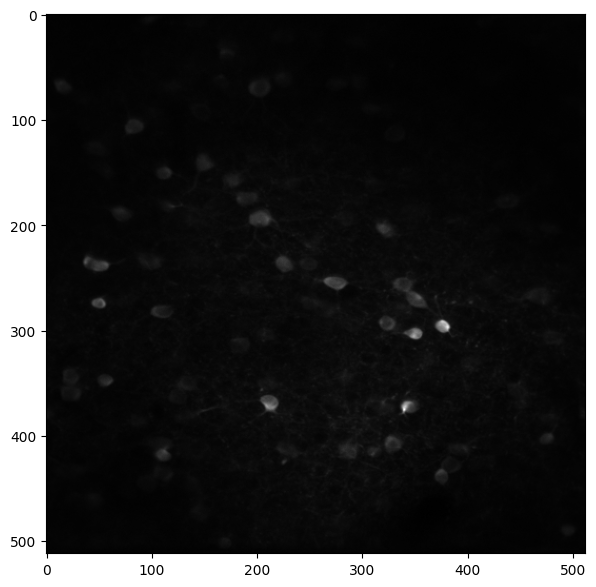

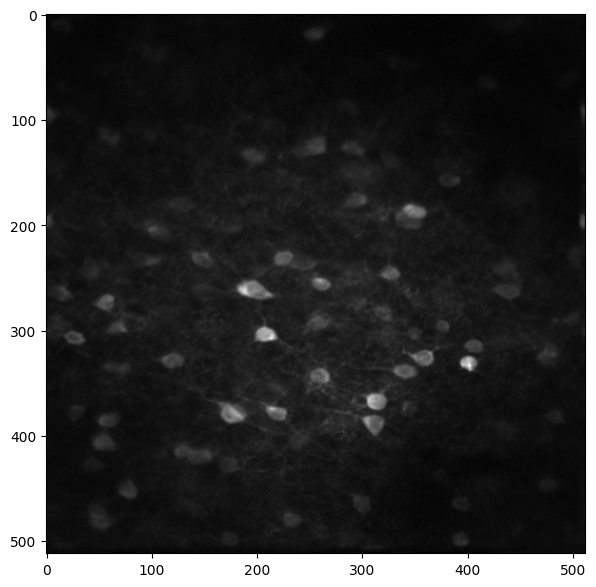

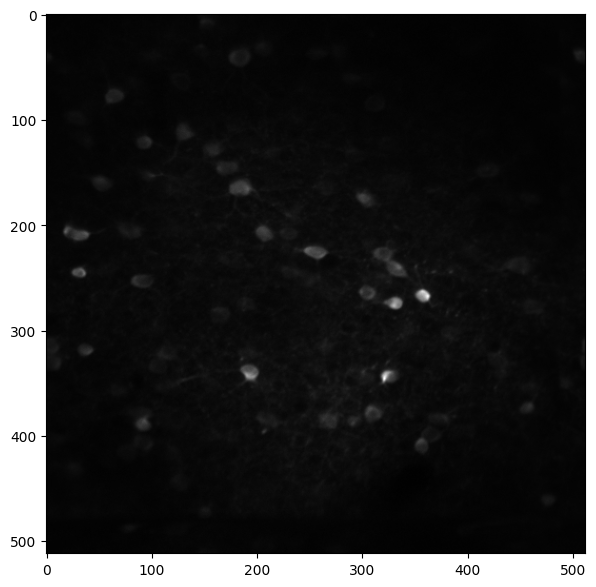

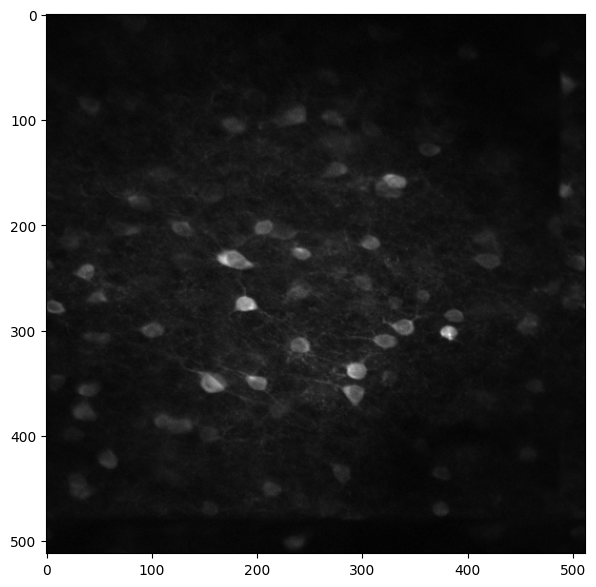

In [52]:
# plot mean of each shifted_frames
for i, frame in enumerate(shifted_frames):
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    plt.imshow(shifted_frames[frame].mean(axis=0),label=i, cmap='gray')
